In [1]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, update_bn

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Lambda
from torchmetrics import MeanMetric
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from glob import glob
from PIL import Image
from IPython.display import display, HTML, clear_output
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [2]:

params={'image_size':128,
        'lr':2e-5,
        'batch_size':8,
        'epochs':10000,
        'data_path':'../../data/dataset/colon_all/',
        'n_step':1000}
class ModelConfig:
    BASE_CH = 128  # 128, 256, 256, 512, 512
    BASE_CH_MULT = (1, 2, 2, 4, 4) # 128, 64, 32, 16, 8
    APPLY_ATTENTION = (False, False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128

In [3]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# def get_default_device():
#     return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_num_parameter(model):
    # Count the number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    return num_params

def save_images(images, path, **kwargs):
    grid = make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

def setup_log_directory(config):
    '''Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory 
    log_dir        = os.path.join(config.root_log_dir,        version_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")
    
    return log_dir, checkpoint_dir

def frames2vid(images, save_path):

    WIDTH = images[0].shape[1]
    HEIGHT = images[0].shape[0]

#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     fourcc = 0
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(save_path, fourcc, 25, (WIDTH, HEIGHT))

    # Appending the images to the video one by one
    for image in images:
        video.write(image)

    # Deallocating memories taken for window creation
    # cv2.destroyAllWindows()
    video.release()
    return

def display_gif(gif_path):
    b64 = base64.b64encode(open(gif_path, 'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

def display_image(image):
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
def inverse_transform(tensors):
    """Convert tensors from [-1, 1] to [0, 255]"""
    return ((tensors.clip(-1, 1) + 1.0) / 2.0) * 255.0

UNet

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)

class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)
        
        return h

class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)

class UpSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding="same")
        )

    def forward(self, x, *args):
        return self.upsample(x)

class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)
                
                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):
        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

dataset

In [5]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.png')
        self.trans_1 = transforms.Compose(
            [
                transforms.Resize((args['image_size'],args['image_size']), interpolation=transforms.InterpolationMode.NEAREST)
            ]
        )
    def trans(self,image_t,a):
        image_t=F.to_tensor(F.rotate(self.trans_1(image_t),a))
        return image_t

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_path[index])
        # augment
        angle=random.randint(0, 360)
        
        image = self.trans_1(F.to_tensor(image)) * 2.0 - 1.0
        
        return image
    
train_dataset=CustomDataset(params,'all')
loader = DataLoader(train_dataset, params['batch_size'], shuffle=True)

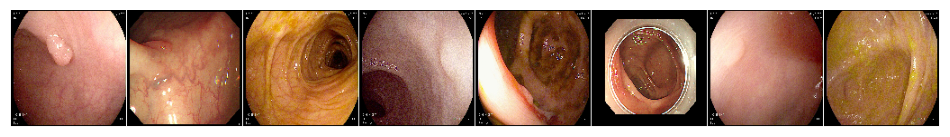

In [6]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image in loader:
    b_image = ((b_image.clip(-1, 1) + 1.0) / 2.0) * 255.0
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    break

Diffusion Process

In [7]:
class SimpleDiffusion(nn.Module):
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
    ):
        super().__init__()
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
                
        # BETAs & ALPHAs required at different places in the Algorithm.
        beta = self.get_betas()
        
        self.register_buffer('beta', beta)
        self.register_buffer('alpha', 1 - beta)
        self.register_buffer('sqrt_beta', torch.sqrt(beta))
        self.register_buffer('alpha_cumulative', torch.cumprod(self.alpha, dim=0))
        self.register_buffer('sqrt_alpha_cumulative', torch.sqrt(self.alpha_cumulative))
        self.register_buffer('one_by_sqrt_alpha', 1. / torch.sqrt(self.alpha))
        self.register_buffer('sqrt_one_minus_alpha_cumulative', torch.sqrt(1 - self.alpha_cumulative))

        
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
        )
        
    def forward(self, x0: torch.Tensor, timesteps: torch.Tensor):
        eps     = torch.randn_like(x0)  # Noise
        mean    = get(self.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
        std_dev = get(self.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
        sample  = mean + std_dev * eps # scaled inputs * scaled noise

        return sample, eps  # return ... , gt noise --> model predicts this)
    
    def reverse(self, x, ts, z, predicted_noise):
        beta_t                            = get(self.beta, ts)
        one_by_sqrt_alpha_t               = get(self.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(self.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
        


Forward Diffusion

In [8]:
model = UNet(
    input_channels          = 3,
    output_channels         = 3,
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
).to(device)

dataloader = DeviceDataLoader(loader, device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = params['n_step'],
    img_shape               = (3, params['image_size'], params['image_size']),
).to(device)

scaler = torch.cuda.amp.GradScaler()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

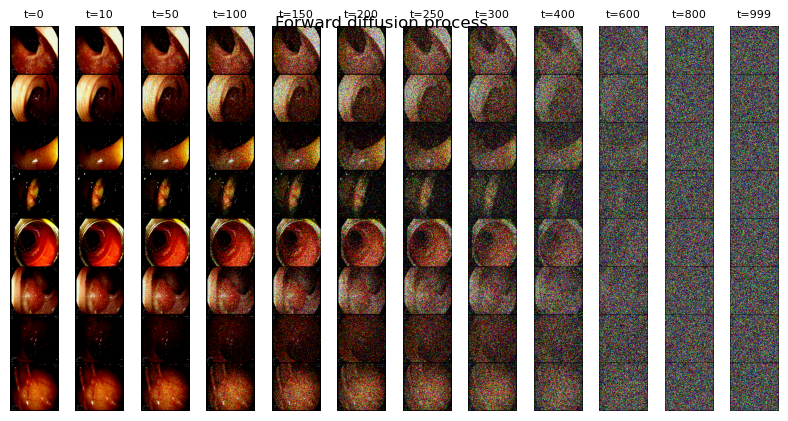

In [9]:

x0s= next(iter(loader)).to(device)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long).to(device)
    xts, _ = sd(x0s, timestep)
    xts = make_grid(xts, nrow=1, padding=1)
    
    noisy_images.append(xts)

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.cpu().squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f't={timestep}',fontsize=8)
    ax[i].axis('off')
    ax[i].grid(False)

plt.suptitle("Forward diffusion process", y=0.9)
plt.axis('off')
plt.show()

In [10]:
def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, total_epochs=params['epochs'],
                   base_config=params, training_config=params):
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{total_epochs}")
         
        for x0s in loader:
            tq.update(1)
            
            ts = torch.randint(low=1, high=training_config['n_step'], size=(x0s.shape[0],), device=device)
            xts, gt_noise = sd(x0s, ts)

            with torch.cuda.amp.autocast():
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss

In [11]:
@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", generate_video=False, **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    if kwargs.get("generate_video", False):
        outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        if generate_video:
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)

    if generate_video: # Generate and save video of the entire reverse process. 
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.

    else: # Display and save the image at the final timestep of the reverse process. 
        x = inverse_transform(x).type(torch.uint8)
        grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        if kwargs.get("save_path", None):
            pil_image.save(kwargs['save_path'], format=kwargs['save_path'].split(".")[-1].upper())
        display_image(grid.permute(1, 2, 0))
    return grid

In [12]:
generate_video = False
ext = ".mp4" if generate_video else ".png"
for epoch in range(1, params['epochs'] + 1):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 100 == 0:
        save_path = '../../data/colon/aa_'+str(epoch)+ext
        
        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=params['n_step'], num_images=32, generate_video=generate_video,
            save_path=save_path, img_shape=(3,params['image_size'],params['image_size']), device=device,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, "../../model/DDPM/model1.ckpt")
        del checkpoint_dict

Train :: Epoch: 1/10000:   8%|▊         | 10/125 [00:07<01:24,  1.36it/s, Loss: 0.8041]


KeyboardInterrupt: 

In [ ]:
reverse_diffusion(model, sd, timesteps=params['n_step'], num_images=32, generate_video=generate_video,
            save_path=save_path, img_shape=(3,params['image_size'],params['image_size']), device=device,
        )

In [ ]:
IMG_EXTENSIONS = set(['png', 'jpg', 'jpeg'])
VIDEO_EXTENSIONS = set(['mp4', 'gif'])

def generate(model, sd, num_images=128, timesteps=1000, nrow=16, format='png', device="cpu"):
    if format in IMG_EXTENSIONS:
        generate_video = False
    elif format in VIDEO_EXTENSIONS:
        generate_video = True
    else:
        print('Unsupported format')
        return

    filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}.{format}"

    save_path = '../../data/colon/'+filename
    reverse_diffusion(
        model,
        sd,
        num_images=num_images,
        generate_video=generate_video,
        save_path=save_path,
        timesteps=timesteps,
        img_shape=(3,params['image_size'],params['image_size']),
        nrow=nrow,
        device=device
    )
    print(save_path)

In [ ]:
generate(model, sd, format='png', device=device)